In [0]:
import tensorflow as tf

In [0]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0


BaseException: ignored

In [0]:
!nvidia-smi

Fri Jun  5 23:20:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    32W / 250W |  12131MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D , ZeroPadding2D,Convolution2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
 
 
import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from tensorflow.python.client import device_lib

In [0]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17228453615706792768
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17418724686959909672
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3303445864595026351
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11862372839142699786
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir("/content/gdrive/My Drive")
os.getcwd()

'/content/gdrive/My Drive'

In [0]:
!ls

 0518hw.docx
 0518hw.docx.gdoc
 123123123
 12_歐陽良祥.rar
'15351 Bestview Ct.gmap'
 1.docx
'ACCOUNTING I.docx'
 aien0712歐陽良祥.gdoc
'A list of math and statistics courses.gdoc'
'A list of math and statistics courses.pdf'
'CellReferences (2) (1).docx'
'CellReferences (2) (1).docx.gdoc'
 Chapter13.gslides
'Colab Notebooks'
 message_zdm.html.gdoc
'MLS-Biology Presentation SARS.gslides'
'MSstatistics_SJSU_PrerequisiteCheckForm (1).gsheet'
 MSstatistics_SJSU_PrerequisiteCheckForm.gsheet
'Numerical Analysis-Burden Faires 9th 数值分析(非扫描).pdf'
'Q1 Speaking Feedback_Lesson 1_HW (1).doc.gdoc'
'Q1 Speaking Feedback_Lesson 1_HW (2).doc.gdoc'
'Q1 Speaking Feedback_Lesson 1_HW.doc'
'Q1 Speaking Feedback_Lesson 1_HW.doc.gdoc'
'Q1 Speaking Feedback_Lesson 1_HW.gdoc'
'Q2 Speaking Feedback_Lesson 2_HW.doc'
'Q2 Speaking Feedback_Lesson 2_HW.doc.gdoc'
'Q2 Speaking Feedback_Lesson 2_HW.gdoc'
 schedule
'sop 歐陽良祥.docx'
'Template Pamphlet_Dad (CHINESE).gdoc'
 test
'TOEFL Speaking (Q3)_HW Feedback_Good Summary.doc'
'

In [0]:
# 資料增強增加數目
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization= False,
                 samplewise_std_normalization= False,
                 zca_whitening=False,
                 rotation_range=10,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.1,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255)

In [0]:
train_generator = train_datagen.flow_from_directory(
        "train",
        target_size=(224,224),       # resize images to (224,224) to increase the training speed and efficiency
        batch_size=300)

Found 2255 images belonging to 3 classes.


In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)    # rescale to [0-1] for testing set

test_generator = test_datagen.flow_from_directory(
        "test",
        target_size=(224,224),
        batch_size=300)

Found 600 images belonging to 3 classes.


In [0]:
# overfitting model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2()))

# 建模型
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# 提早停止
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
# 自動調整learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit_generator(train_generator,steps_per_epoch=15,
                              validation_data=test_generator,validation_steps=6, 
                              epochs=200)

Epoch 1/200
15/15 [==============================] - 618s 41s/step - loss: 1.1641 - accuracy: 0.3773 - val_loss: 1.0884 - val_accuracy: 0.4183
Epoch 2/200
15/15 [==============================] - 26s 2s/step - loss: 1.0794 - accuracy: 0.4560 - val_loss: 1.0179 - val_accuracy: 0.5267
Epoch 3/200
15/15 [==============================] - 26s 2s/step - loss: 0.9735 - accuracy: 0.5453 - val_loss: 1.0218 - val_accuracy: 0.5617
Epoch 4/200
15/15 [==============================] - 26s 2s/step - loss: 0.9451 - accuracy: 0.5420 - val_loss: 1.0174 - val_accuracy: 0.5250
Epoch 5/200
15/15 [==============================] - 26s 2s/step - loss: 0.9375 - accuracy: 0.5440 - val_loss: 0.8670 - val_accuracy: 0.5800
Epoch 6/200
15/15 [==============================] - 26s 2s/step - loss: 0.8914 - accuracy: 0.5627 - val_loss: 0.9061 - val_accuracy: 0.5767
Epoch 7/200
15/15 [==============================] - 26s 2s/step - loss: 0.8583 - accuracy: 0.5733 - val_loss: 1.0509 - val_accuracy: 0.5350
Epoch 8/200

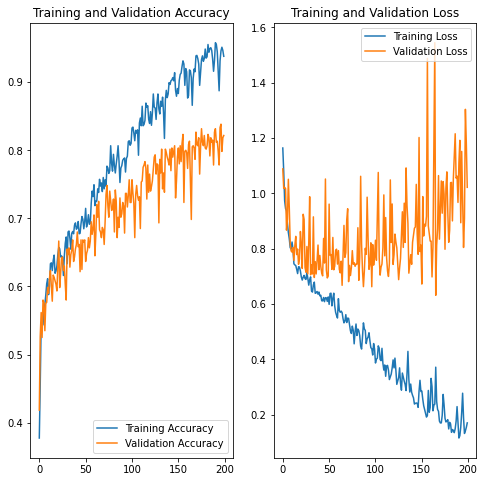

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(200)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 32)      2432      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 226, 226, 32)      25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 113, 113, 32)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 115, 115, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 115, 115, 64)     

In [0]:
#  model2
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2()))

# 建模型
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# 提早停止
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
# 自動調整learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

# tf.keras.optimizers.Adam(
#     learning_rate=0.0001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     name="Adam")

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 32)      2432      
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 226, 226, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 226, 226, 32)      25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 113, 113, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 113, 113, 32)      0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 115, 115, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 115, 115, 64)     

In [0]:
history = model.fit(train_generator,steps_per_epoch=5,
                    validation_data=test_generator,validation_steps=2, 
                    epochs=200,callbacks=[checkpointer,earlystopping,reduceLR])

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: 1.4830 - accuracy: 0.3493
Epoch 00001: val_loss improved from inf to 1.15466, saving model to model.hdf5
5/5 [==============================] - 24s 5s/step - loss: 1.4830 - accuracy: 0.3493 - val_loss: 1.1547 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 1.1604 - accuracy: 0.3213
Epoch 00002: val_loss improved from 1.15466 to 1.14945, saving model to model.hdf5
5/5 [==============================] - 24s 5s/step - loss: 1.1604 - accuracy: 0.3213 - val_loss: 1.1494 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 1.1496 - accuracy: 0.3180
Epoch 00003: val_loss improved from 1.14945 to 1.12683, saving model to model.hdf5
5/5 [==============================] - 24s 5s/step - loss: 1.1496 - accuracy: 0.3180 - val_loss: 1.1268 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - ETA: 

In [0]:
#參數多的時候下面可以加dropout(p) p越高test performance 越高
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

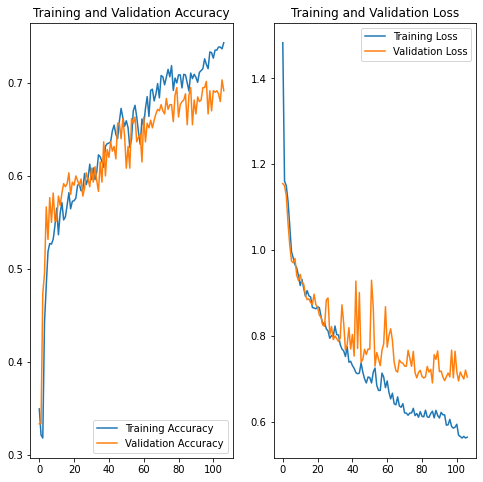

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(107)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# model.add(ZeroPadding2D((1,1),input_shape=(3,256,256)))
# model.add(Convolution2D(64, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(64, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2),data_format ="channels_first"))

# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(128, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(128, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2),data_format ="channels_first"))

# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(256, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(256, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(256, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(256, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2),data_format ="channels_first"))

# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2),data_format ="channels_first"))

# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2),data_format ="channels_first"))

# model.add(Flatten())
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2()))

AttributeError: ignored

In [0]:
#  model2
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu', input_shape = (256,256,3), kernel_initializer='he_normal'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2()))

# 保留最佳模型
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# 提早停止
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
# 自動調整learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

# tf.keras.optimizers.Adam(
#     learning_rate=0.0001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     name="Adam")

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit(train_generator,steps_per_epoch=15,
                    validation_data=test_generator,validation_steps=6, 
                    epochs=200,callbacks=[checkpointer,earlystopping,reduceLR])

Epoch 1/200
15/15 [==============================] - ETA: 0s - loss: 2.1061 - accuracy: 0.3147
Epoch 00001: val_loss improved from inf to 1.15176, saving model to model.hdf5
15/15 [==============================] - 28s 2s/step - loss: 2.1061 - accuracy: 0.3147 - val_loss: 1.1518 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 1.1504 - accuracy: 0.3393
Epoch 00002: val_loss improved from 1.15176 to 1.14797, saving model to model.hdf5
15/15 [==============================] - 29s 2s/step - loss: 1.1504 - accuracy: 0.3393 - val_loss: 1.1480 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1.1465 - accuracy: 0.3627
Epoch 00003: val_loss improved from 1.14797 to 1.14134, saving model to model.hdf5
15/15 [==============================] - 29s 2s/step - loss: 1.1465 - accuracy: 0.3627 - val_loss: 1.1413 - val_accuracy: 0.3683 - lr: 0.0010
Epoch 4/200
15/15 [=========================

In [0]:
train_generator = train_datagen.flow_from_directory(
        "train",
        target_size=(256,256),       # resize images to (224,224) to increase the training speed and efficiency
        batch_size=100)
test_datagen = ImageDataGenerator(rescale=1./255)    # rescale to [0-1] for testing set

test_generator = test_datagen.flow_from_directory(
        "test",
        target_size=(256,256),
        batch_size=100)

Found 1500 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


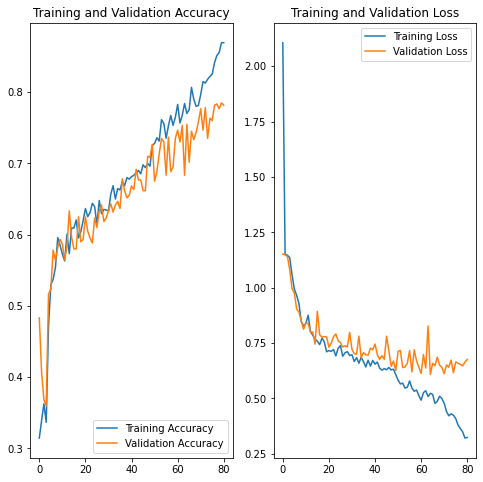

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(81)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#test 4
train_generator = train_datagen.flow_from_directory(
        "train",
        target_size=(256,256),       # resize images to (224,224) to increase the training speed and efficiency
        batch_size=128)
test_datagen = ImageDataGenerator(rescale=1./255)    # rescale to [0-1] for testing set

test_generator = test_datagen.flow_from_directory(
        "test",
        target_size=(256,256),
        batch_size=128)

Found 2246 images belonging to 3 classes.
Found 599 images belonging to 3 classes.


In [0]:
#  model2 kernel_size 大到小 資料清洗
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu', input_shape = (256,256,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 1, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(faltt())

model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2()))

# 保留最佳模型
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# 提早停止
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
# 自動調整learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=9, mode='auto')

x= tf.keras.optimizers.Adam(
    learning_rate=0.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")

model.compile(optimizer = x , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit(train_generator,steps_per_epoch=2255//128,
                    validation_data=test_generator,validation_steps=600//128, 
                    epochs=200,callbacks=[checkpointer,earlystopping,reduceLR])

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 2.1341 - accuracy: 0.3390 
Epoch 00001: val_loss improved from inf to 1.15600, saving model to model.hdf5
17/17 [==============================] - 646s 38s/step - loss: 2.1341 - accuracy: 0.3390 - val_loss: 1.1560 - val_accuracy: 0.3223 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 1.1520 - accuracy: 0.3480
Epoch 00002: val_loss improved from 1.15600 to 1.15083, saving model to model.hdf5
17/17 [==============================] - 42s 2s/step - loss: 1.1520 - accuracy: 0.3480 - val_loss: 1.1508 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 1.1463 - accuracy: 0.3650
Epoch 00003: val_loss improved from 1.15083 to 1.14837, saving model to model.hdf5
17/17 [==============================] - 42s 2s/step - loss: 1.1463 - accuracy: 0.3650 - val_loss: 1.1484 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 4/200
17/17 [======================

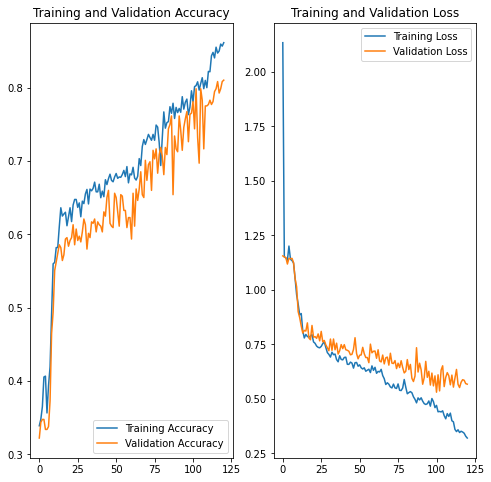

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(121)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#?????不會用
x =tf.keras.optimizers.Adam(
    learning_rate=0.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")

In [0]:
#  model2 kernel_size 大到小 資料清洗
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (256,256,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2()))

# 保留最佳模型
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# 提早停止
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
# 自動調整learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=9, mode='auto')


model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit(train_generator,steps_per_epoch=2255//128,
                    validation_data=test_generator,validation_steps=600//128, 
                    epochs=200,callbacks=[checkpointer,earlystopping,reduceLR])

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 3.2481 - accuracy: 0.3584
Epoch 00001: val_loss improved from inf to 1.15250, saving model to model.hdf5
17/17 [==============================] - 41s 2s/step - loss: 3.2481 - accuracy: 0.3584 - val_loss: 1.1525 - val_accuracy: 0.3340 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 1.1472 - accuracy: 0.3527
Epoch 00002: val_loss improved from 1.15250 to 1.15167, saving model to model.hdf5
17/17 [==============================] - 41s 2s/step - loss: 1.1472 - accuracy: 0.3527 - val_loss: 1.1517 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 1.1439 - accuracy: 0.3744
Epoch 00003: val_loss improved from 1.15167 to 1.14945, saving model to model.hdf5
17/17 [==============================] - 42s 2s/step - loss: 1.1439 - accuracy: 0.3744 - val_loss: 1.1494 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 4/200
17/17 [=========================

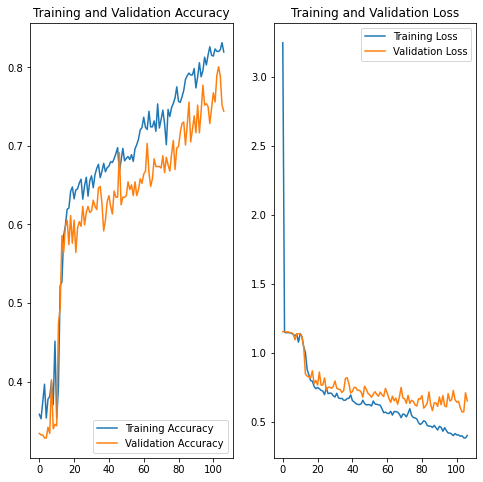

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(107)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#test 5
train_generator = train_datagen.flow_from_directory(
        "train",
        target_size=(256,256),       # resize images to (224,224) to increase the training speed and efficiency
        batch_size=256)
test_datagen = ImageDataGenerator(rescale=1./255)    # rescale to [0-1] for testing set

test_generator = test_datagen.flow_from_directory(
        "test",
        target_size=(256,256),
        batch_size=256)

Found 2246 images belonging to 3 classes.
Found 599 images belonging to 3 classes.


In [0]:
x =tf.keras.optimizers.Adam(
    learning_rate=0.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")

In [0]:
#  model2 kernel_size 大到小 資料清洗
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (256,256,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2()))

# 保留最佳模型
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# 提早停止
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=30, mode='auto')
# 自動調整learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=9, mode='auto')


model.compile(optimizer = x , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit(train_generator,steps_per_epoch=2255//256,
                    validation_data=test_generator,validation_steps=599//256, 
                    epochs=200,callbacks=[checkpointer,earlystopping,reduceLR])

Epoch 1/200
8/8 [==============================] - ETA: 0s - loss: 3.1516 - accuracy: 0.3467  
Epoch 00001: val_loss improved from inf to 1.15611, saving model to model.hdf5
8/8 [==============================] - 1313s 164s/step - loss: 3.1516 - accuracy: 0.3467 - val_loss: 1.1561 - val_accuracy: 0.3379 - lr: 0.0020
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 1.1507 - accuracy: 0.3533
Epoch 00002: val_loss improved from 1.15611 to 1.15497, saving model to model.hdf5
8/8 [==============================] - 33s 4s/step - loss: 1.1507 - accuracy: 0.3533 - val_loss: 1.1550 - val_accuracy: 0.3379 - lr: 0.0020
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 1.1478 - accuracy: 0.3583
Epoch 00003: val_loss did not improve from 1.15497
8/8 [==============================] - 32s 4s/step - loss: 1.1478 - accuracy: 0.3583 - val_loss: 1.1553 - val_accuracy: 0.3320 - lr: 0.0020
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss: 1.1428 - accura

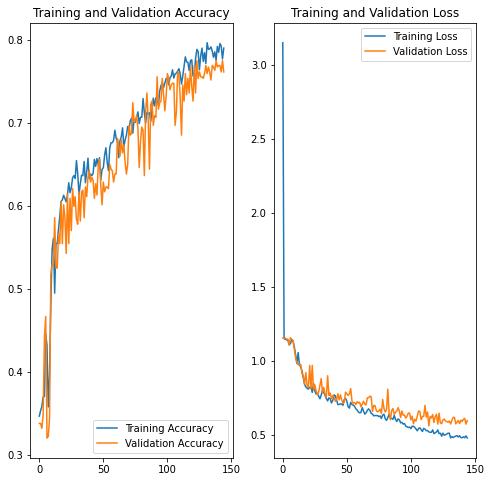

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(145)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()